This is a prototype of a time series using Recurrent Neural Network (RNN) using Gated Recurrent Unit (GRU) to predict energy consumption patterns.

This model uses a singular series of data over a period of 15 months to train and then is tested over a further 12 months of data. Predictions over a long period of time can make this model unstable.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
%matplotlib inline

Open source energy consumption data used from london.gov.uk
For more information about the data and to download the entire set visit https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

In [2]:
# import data and set DateTime column as index
energy_data_frame = pd.read_csv('./data/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv', index_col='DateTime')

In [3]:
# a view of the head
energy_data_frame.head()

,LCLid,stdorToU,KWH/hh (per half hour),Acorn,Acorn_grouped
DateTime,,,,,
2012-10-12 00:30:00.0000000,MAC000002,Std,0,ACORN-A,Affluent
2012-10-12 01:00:00.0000000,MAC000002,Std,0,ACORN-A,Affluent
2012-10-12 01:30:00.0000000,MAC000002,Std,0,ACORN-A,Affluent
2012-10-12 02:00:00.0000000,MAC000002,Std,0,ACORN-A,Affluent
2012-10-12 02:30:00.0000000,MAC000002,Std,0,ACORN-A,Affluent


In [4]:
# set index for timeseries
energy_data_frame.index = pd.to_datetime(energy_data_frame.index, infer_datetime_format=True)

In [5]:
# remove unused columns
energy_data_frame = energy_data_frame.drop(['stdorToU', 'Acorn', 'Acorn_grouped'], axis=1)

In [6]:
# convert consumption data to numeric and append as consumption
energy_data_frame['consumption'] = pd.to_numeric(energy_data_frame['KWH/hh (per half hour) '], errors='coerce')

In [7]:
# remove old consumption data
energy_data_frame = energy_data_frame.drop(['KWH/hh (per half hour) '], axis=1)

In [8]:
# rotate to make each id into a series
energy_data_frame = energy_data_frame.pivot_table(values='consumption', index=['DateTime'], columns=['LCLid'] )

In [9]:
# convert to monthly sum
energy_data_frame = energy_data_frame.resample('m').sum()

In [10]:
# a view of the head
pd.set_option('display.max_columns', 36)
energy_data_frame.head()

LCLid,MAC000002,MAC000003,MAC000004,MAC000006,MAC000007,MAC000008,MAC000009,MAC000010,MAC000011,MAC000012,MAC000013,MAC000016,MAC000018,MAC000019,MAC000020,MAC000021,MAC000022,MAC000023,MAC000024,MAC000025,MAC000026,MAC000027,MAC000028,MAC000029,MAC000030,MAC000032,MAC000033,MAC000034,MAC000035,MAC000036
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-12-31,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.084,293.250,152.834,216.473,613.345,321.129,349.989999,686.478000,106.731,343.882,238.418,141.462,100.222,423.296000,399.346000,188.099,739.998999,641.381000,64.341
2012-01-31,0.0,0.000000,0.0,6.068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.356,440.327,244.380,263.101,693.873,589.004,595.093000,855.176999,153.153,337.374,279.544,184.386,113.675,416.446000,568.613999,243.127,1522.652998,815.847000,79.859
2012-02-29,0.0,178.853999,0.0,92.950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.874,516.231,207.274,234.602,723.946,576.794,465.997000,1076.014000,138.633,396.421,294.268,164.229,99.780,359.421001,547.161000,349.355,1710.679998,1098.305999,80.410
2012-03-31,0.0,552.333001,0.0,87.244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.203,367.937,135.808,201.061,678.280,420.534,612.121999,601.554999,155.174,464.515,305.261,154.624,113.367,236.382000,369.767000,275.608,1626.170001,597.507000,84.604
2012-04-30,0.0,441.004001,0.0,88.049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.535,282.840,185.991,195.589,734.623,326.090,419.659999,591.235998,144.903,396.014,289.778,154.316,118.584,282.014000,370.034000,230.244,1096.366999,716.357000,83.698


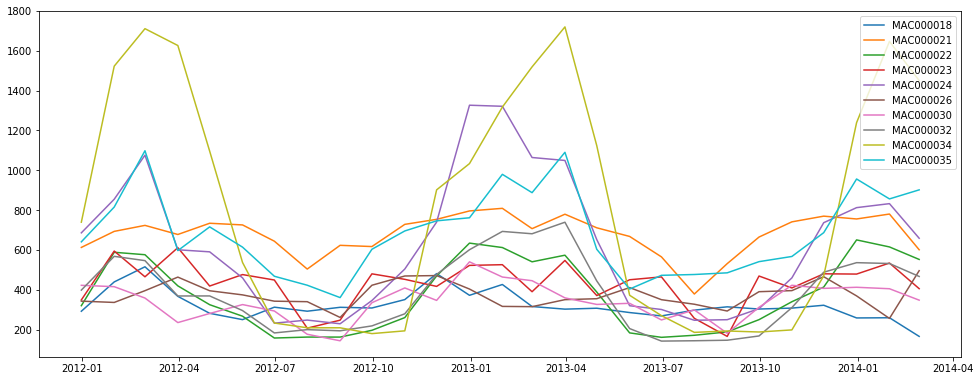

In [11]:
# plot the data of complete rows with consumption
fig = plt.figure(figsize=(16, 6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(energy_data_frame['MAC000018'])
axes.plot(energy_data_frame['MAC000021'])
axes.plot(energy_data_frame['MAC000022'])
axes.plot(energy_data_frame['MAC000023'])
axes.plot(energy_data_frame['MAC000024'])
axes.plot(energy_data_frame['MAC000026'])
axes.plot(energy_data_frame['MAC000030'])
axes.plot(energy_data_frame['MAC000032'])
axes.plot(energy_data_frame['MAC000034'])
axes.plot(energy_data_frame['MAC000035'])
axes.legend()

In [12]:
# retrict data set to a single LCLid
energy_data_id34 = pd.DataFrame(index=energy_data_frame.index, columns=['MAC000034'])

In [13]:
# create data frame from single id
energy_data_id34['MAC000034']  = energy_data_frame['MAC000034']

In [14]:
energy_data_id34.head()

,MAC000034
DateTime,
2011-12-31,739.998999
2012-01-31,1522.652998
2012-02-29,1710.679998
2012-03-31,1626.170001
2012-04-30,1096.366999


In [15]:
energy_data_id34.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 2011-12-31 to 2014-02-28
Freq: M
Data columns (total 1 columns):
MAC000034    27 non-null float64
dtypes: float64(1)
memory usage: 432.0 bytes


In [16]:
# training and test set
training_set = energy_data_id34.head(15)
test_set = energy_data_id34.tail(12)

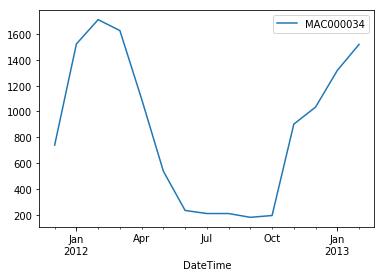

In [17]:
# plot training data
training_set.plot()

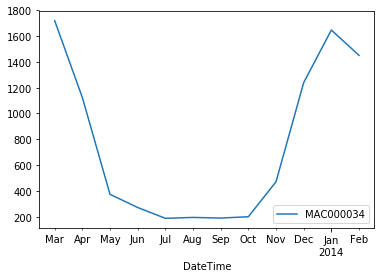

In [18]:
test_set.plot()

In [19]:
# scale data, fit is only performed on the training data
train_scaled = scaler.fit_transform(training_set)
test_scaled = scaler.transform(test_set)

In [20]:
# set hyper parameters
num_inputs = 1
num_time_steps = 6
num_neurons = 300
num_pred = 2
num_outputs = 1
learning_rate = 0.02
num_train_iterations = 10000
batch_size = 1

In [21]:
# set placeholders
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [22]:
# set model type
cell = tf.contrib.rnn.OutputProjectionWrapper(
  tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu), output_size=num_outputs)

In [23]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [24]:
# model config
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
loss = tf.reduce_mean(tf.square(outputs - y))
train = optimizer.minimize(loss)
saver = tf.train.Saver()

In [25]:
def next_batch(training_data, batch_size, steps):
    # select a random slice of data to minimise overfitting
    rand_start = np.random.randint(0, len(training_data) - (steps + num_pred))
    y_batch = np.array(training_data[rand_start:rand_start + steps + num_pred]).reshape(1, steps + num_pred)
    return y_batch[:, :-num_pred].reshape(-1, steps, 1), y_batch[:, num_pred:].reshape(-1, steps, 1)

In [26]:
# this block of code trains the model and writes the saved model
# to retrain the model uncomment the code below
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     for iteration in range(num_train_iterations):
#         X_batch, y_batch = next_batch(train_scaled, batch_size, num_time_steps)
#         sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
#         if iteration % 1000 == 0:
#             mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
#             print(iteration, "\tMSE", mse)
    
#     # Save Model
#     saver.save(sess, "./energy_consumption_singular_model/energy_consumption_model")

In [27]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./energy_consumption_singular_model/energy_consumption_model")

    train_seed = list(train_scaled[:-1])
    
    for iteration in range(len(test_set)):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./energy_consumption_singular_model/energy_consumption_model


In [28]:
results = scaler.inverse_transform(np.array(train_seed[-len(test_set):]).reshape(len(test_set), 1))

In [29]:
test_set['Predicted'] = results

c:\users\mrehm\anaconda3\envs\primary\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


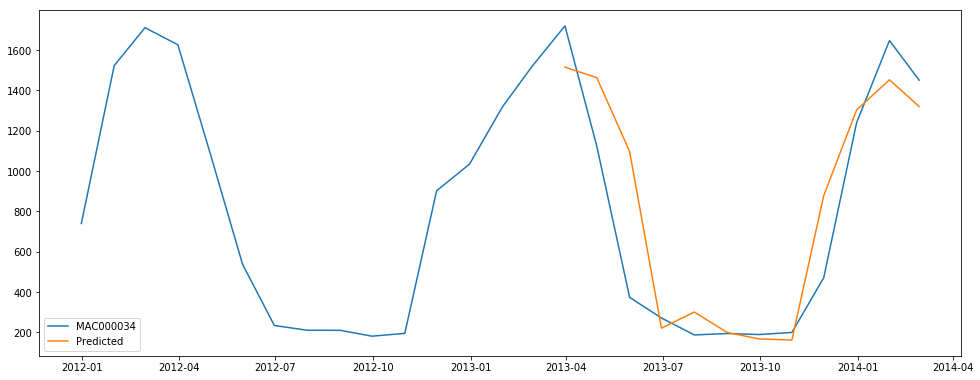

In [30]:
fig = plt.figure(figsize=(16, 6))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(energy_data_id34['MAC000034'])
axes.plot(test_set['Predicted'])
axes.legend()